# Masking and processing

## ❓ Questions
- How can I crop my raster data to the area of interest?


## ❗ Objectives
- Crop raster data with a bounding box.
- Crop raster data with a polygon.
- Match two raster datasets in different CRS.





# Visualisation

## Finding the files
Before we can load the data files into python, we first need to navigate to them on our computer. For Sentinel 2 files, these come in the "SAFE" standard.

In [118]:
# Get the directory again
import os

product_dir_textfile = "product_dir.txt"

with open(product_dir_textfile, 'r') as f:
    base_product_dir = f.readline()

base_product_dir

'/data/ASDAF_Workshop_Materials_Remote_Sensing_Intro/notebooks/workshop_data/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459.SAFE'

In [119]:
from os.path import join

product_dir = join(base_product_dir, 'GRANULE')
L2_dirname = os.listdir(product_dir)[0]
product_dir = join(product_dir, L2_dirname)
product_dir = join(product_dir, 'IMG_DATA', 'R60m')
os.listdir(product_dir)

['T50HMK_20230824T021351_B12_60m.jp2',
 'T50HMK_20230824T021351_TCI_60m.jp2',
 'T50HMK_20230824T021351_WVP_60m.jp2',
 'T50HMK_20230824T021351_B06_60m.jp2',
 'T50HMK_20230824T021351_B07_60m.jp2',
 'T50HMK_20230824T021351_B09_60m.jp2',
 'T50HMK_20230824T021351_B11_60m.jp2',
 'T50HMK_20230824T021351_B02_60m.jp2',
 'T50HMK_20230824T021351_B03_60m.jp2',
 'T50HMK_20230824T021351_B8A_60m.jp2',
 'T50HMK_20230824T021351_B01_60m.jp2',
 'T50HMK_20230824T021351_AOT_60m.jp2',
 'T50HMK_20230824T021351_B04_60m.jp2',
 'T50HMK_20230824T021351_B05_60m.jp2',
 'T50HMK_20230824T021351_SCL_60m.jp2']

In [120]:
# Get a dictionary of filenames
image_paths = {}
for fname in os.listdir(product_dir):
    fpath = join(product_dir, fname)
    file_band = fname.split('_')[2]
    image_paths[file_band] = fpath

image_paths

{'B12': '/data/ASDAF_Workshop_Materials_Remote_Sensing_Intro/notebooks/workshop_data/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459.SAFE/GRANULE/L2A_T50HMK_A042671_20230824T022008/IMG_DATA/R60m/T50HMK_20230824T021351_B12_60m.jp2',
 'TCI': '/data/ASDAF_Workshop_Materials_Remote_Sensing_Intro/notebooks/workshop_data/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459.SAFE/GRANULE/L2A_T50HMK_A042671_20230824T022008/IMG_DATA/R60m/T50HMK_20230824T021351_TCI_60m.jp2',
 'WVP': '/data/ASDAF_Workshop_Materials_Remote_Sensing_Intro/notebooks/workshop_data/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459.SAFE/GRANULE/L2A_T50HMK_A042671_20230824T022008/IMG_DATA/R60m/T50HMK_20230824T021351_WVP_60m.jp2',
 'B06': '/data/ASDAF_Workshop_Materials_Remote_Sensing_Intro/notebooks/workshop_da

# Sentinel 2 Data

![Common bands](../notebook_pictures/dmidS2LS7Comparison.png)  
Comparison of Landsat 7 and 8 bands with Sentinel-2, USGS Public Domain Image

## What's in a raster?

In [121]:
image_paths

{'B12': '/data/ASDAF_Workshop_Materials_Remote_Sensing_Intro/notebooks/workshop_data/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459.SAFE/GRANULE/L2A_T50HMK_A042671_20230824T022008/IMG_DATA/R60m/T50HMK_20230824T021351_B12_60m.jp2',
 'TCI': '/data/ASDAF_Workshop_Materials_Remote_Sensing_Intro/notebooks/workshop_data/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459.SAFE/GRANULE/L2A_T50HMK_A042671_20230824T022008/IMG_DATA/R60m/T50HMK_20230824T021351_TCI_60m.jp2',
 'WVP': '/data/ASDAF_Workshop_Materials_Remote_Sensing_Intro/notebooks/workshop_data/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459/S2A_MSIL2A_20230824T021351_N0509_R060_T50HMK_20230824T070459.SAFE/GRANULE/L2A_T50HMK_A042671_20230824T022008/IMG_DATA/R60m/T50HMK_20230824T021351_WVP_60m.jp2',
 'B06': '/data/ASDAF_Workshop_Materials_Remote_Sensing_Intro/notebooks/workshop_da

In [175]:
import rioxarray


raster_s2_tci = rioxarray.open_rasterio(image_paths['TCI'])

In [176]:
# Check out some attributes
raster_s2_tci

<xarray.DataArray (band: 3, y: 1830, x: 1830)> Size: 10MB
[10046700 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 15kB 4e+05 4e+05 4.001e+05 ... 5.097e+05 5.097e+05
  * y            (y) float64 15kB 6.5e+06 6.5e+06 6.5e+06 ... 6.39e+06 6.39e+06
    spatial_ref  int64 8B 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [177]:
# save portion of an image to disk
subset_tci = raster_s2_tci[:, 100:500, 100:500]
subset_tci

<xarray.DataArray (band: 3, y: 400, x: 400)> Size: 480kB
[480000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 3kB 4.06e+05 4.06e+05 ... 4.299e+05 4.299e+05
  * y            (y) float64 3kB 6.494e+06 6.494e+06 ... 6.47e+06 6.47e+06
    spatial_ref  int64 8B 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [178]:
# Write to disk and check it out!
subset_tci.rio.to_raster('test.tif')

# Loading in vector data

In [179]:
# Load in AOI
import geopandas as gpd

john_forrest_poly_fname = "../data/john_forrest_rough.shp"
AOI_4326 =  gpd.read_file(john_forrest_poly_fname)

In [180]:
# Check out parameters of the polygon(s) we loaded
AOI_4326.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [140]:
# Make sure they're both in the same CRS
# Only run this cell once!
AOI = AOI_4326.to_crs(raster_s2_tci.rio.crs)

# Crop raster data witha  bounding box
The clip_box function allows one to crop a raster by the min/max of the x and y coordinates.   
Note that we are cropping the original image raster now (`raster_s2_tci`), and not the roughly subset image `subset_tci`.

In [143]:
raster_clip_box = raster_s2_tci.rio.clip_box(*AOI.total_bounds)

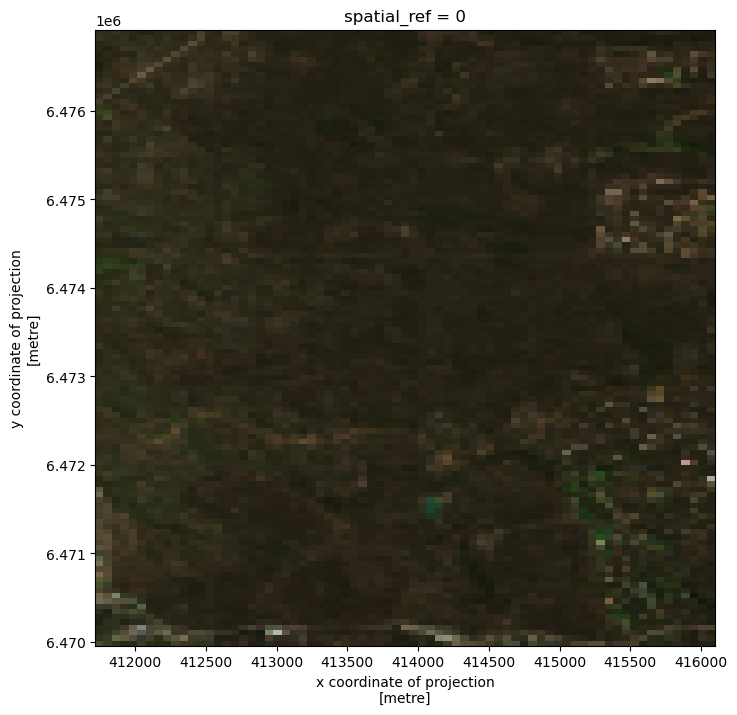

In [148]:
raster_clip_box.plot.imshow(figsize=(8,8))

# Precise raster data cropping with polygons
We have a cropped image around the polygon. To further analyze the image, one may want to crop the image to the exact polygon boundaries.   
This can be done with the clip function:

In [144]:
raster_clip_JF = raster_clip_box.rio.clip(AOI['geometry'])

/home/ubuntu/miniforge3/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


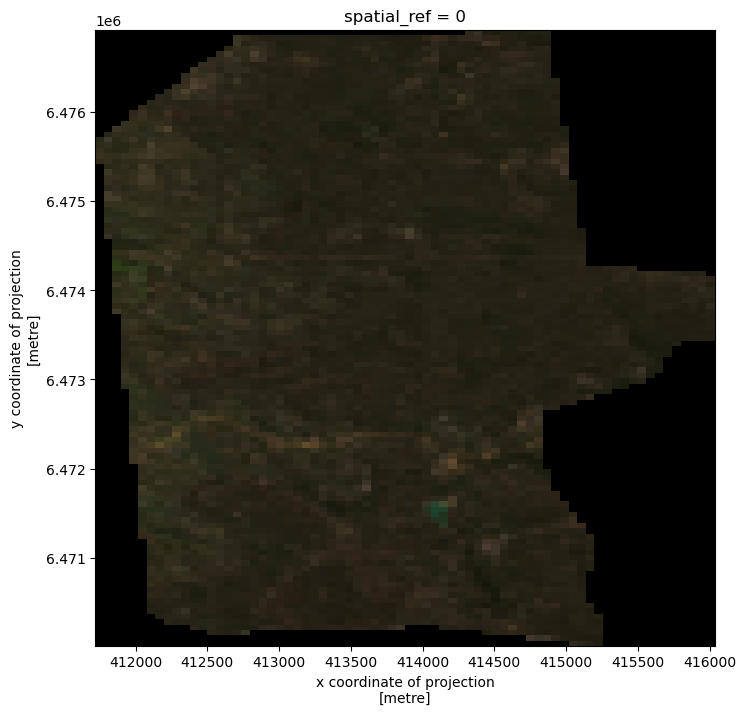

In [149]:
raster_clip_JF.plot.imshow(figsize=(8,8))

## Cropping raster data using the `reproject_match()` method
So far we have learned how to crop raster images with vector data. We can also crop a raster with another raster data.  
To do this, we will use the reproject_match function. As indicated by its name, it performs reprojection and clipping in one go.  

`reproject_match` is an incredibly useful function.   
In addition to clipping and reprojecting, it will also ensure that pixels in each image match up with each other, allowing easy comparison between even disparate datasets.   
For example, it will allow combining reprojecting Landsat 8 imagery to Sentinel 2 for comparison of metrics (reflectance, NDVI, etc)

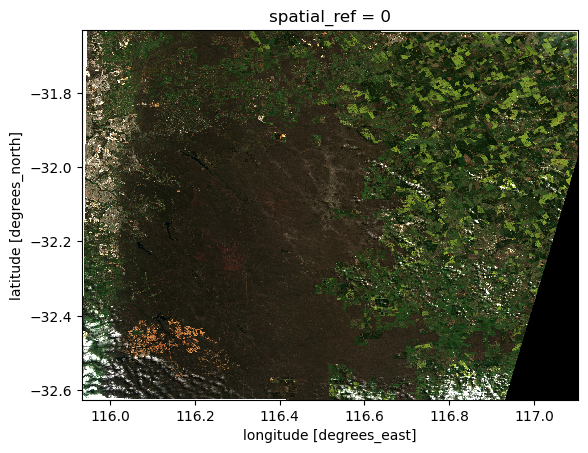

In [184]:
# First, artificially change the data to show the utility of reproject_match
fake_raster = raster_s2_tci.rio.reproject("EPSG:4326")
fake_raster.plot.imshow()

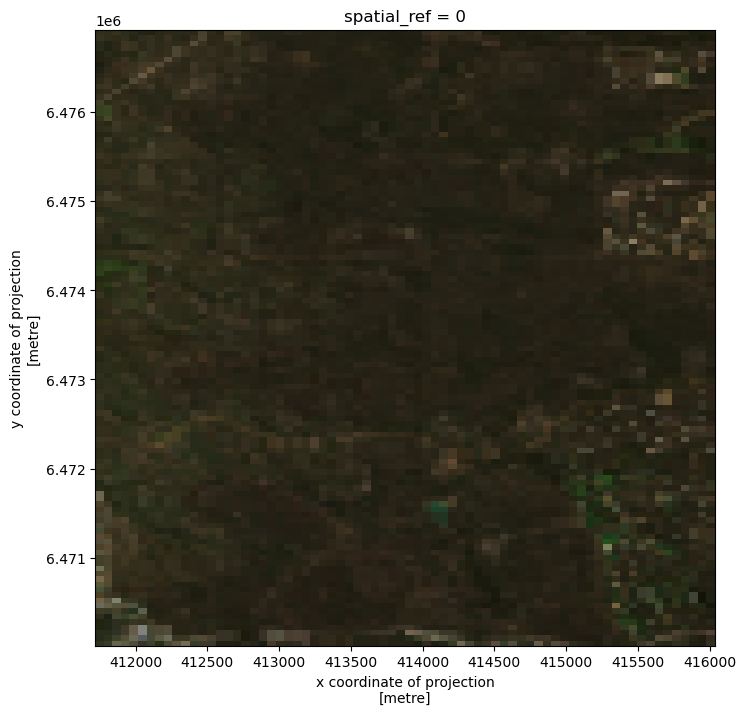

In [185]:
# Now lets reproject match
fake_raster_clip = fake_raster.rio.reproject_match(raster_clip_JF)
fake_raster_clip.plot.imshow(figsize=(8,8))

We can also use this function to expand and image

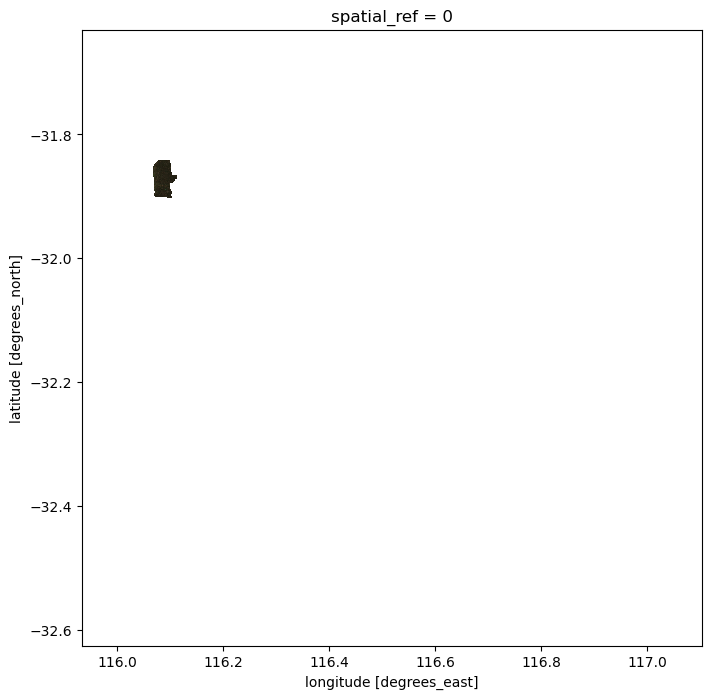

In [190]:
# Now lets reproject match

# Set nodata properly for int8
raster_clip_JF.data[raster_clip_JF.data == 0] = 255 

fake_reproject_match = raster_clip_JF.rio.reproject_match(fake_raster)
fake_reproject_match.plot.imshow(figsize=(8,8))

In one line reproject_match does a lot of helpful things:

1. It reprojects (both with a CRS and aligning offset pixels).
2. It matches the extent using nodata values or by clipping the data.
3. It sets nodata values. This means we can run calculations on those two images.


# 📢 Key Points

- Use `clip_box` to crop a raster with a bounding box
- Use `clip` to crop a raster with a given polygon
- For efficiency, its usually recommended to `clip_box` then `clip`
- Use `reproject_match` to match two raster datasets (e.g. for comparison)